# Support Vector Machines (SVM)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

# For SVM implementation from scikit-learn
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import make_classification, make_blobs, make_circles, load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

# For visualization
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from sklearn.inspection import DecisionBoundaryDisplay

# For interactive plots
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, Markdown, HTML

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# 1. SVM Implementation from Scratch

## 1.1 Linear SVM Implementation from Scratch

In [3]:
class LinearSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param  # Regularization parameter
        self.n_iterations = n_iterations
        self.w = None
        self.b = None
        self.losses = []

    def _init_weights_bias(self, X):
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        self.b = 0

    def _hinge_loss(self, X, y):
        """
        Compute the hinge loss for the SVM.
        """
        n_samples = X.shape[0]
        # Calculate wx + b for all samples
        scores = np.dot(X, self.w) + self.b
        # Calculate max(0, 1 - y * (wx + b)) for all samples
        margins = np.maximum(0, 1 - y * scores)
        # Calculate hinge loss
        loss = self.lambda_param * 0.5 * np.dot(self.w, self.w) + np.sum(margins) / n_samples
        return loss

    def _gradient_descent_step(self, X, y):
        """
        Perform one step of gradient descent to update weights and bias.
        """
        n_samples = X.shape[0]

        # Calculate scores
        scores = np.dot(X, self.w) + self.b

        # Calculate gradients
        # For points where margin < 1, gradient includes both regularization and hinge loss terms
        # For points where margin >= 1, gradient includes only regularization term
        dw = self.lambda_param * self.w
        db = 0

        for i in range(n_samples):
            if y[i] * scores[i] < 1:
                dw -= (X[i] * y[i]) / n_samples
                db -= y[i] / n_samples

        # Update weights and bias
        self.w -= self.lr * dw
        self.b -= self.lr * db

    def fit(self, X, y):
        """
        Train the linear SVM on the provided data.
        """
        # Initialize weights and bias
        self._init_weights_bias(X)

        # Store losses during training for visualization
        self.losses = []

        # Train for n_iterations
        for i in range(self.n_iterations):
            self._gradient_descent_step(X, y)

            # Calculate and store loss every 100 iterations
            if i % 100 == 0:
                loss = self._hinge_loss(X, y)
                self.losses.append(loss)

        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.
        """
        scores = np.dot(X, self.w) + self.b
        return np.sign(scores)

    def decision_function(self, X):
        """
        Return the decision function values for samples in X.
        """
        return np.dot(X, self.w) + self.b

    def get_support_vectors(self, X, y, threshold=1e-5):
        """
        Identify the support vectors based on margin.
        """
        scores = np.dot(X, self.w) + self.b
        margins = y * scores

        # Points with margin close to 1 are support vectors
        support_vector_indices = np.where(np.abs(margins - 1) < threshold)[0]
        return X[support_vector_indices], y[support_vector_indices], support_vector_indices

## 1.2 Kernel SVM Implementation from Scratch

In [4]:
class KernelSVM:
    def __init__(self, C=1.0, kernel='rbf', gamma=0.1, degree=3, max_iter=100, tol=1e-3):
        self.C = C  # Regularization parameter
        self.kernel_name = kernel
        self.gamma = gamma  # RBF kernel parameter
        self.degree = degree  # Polynomial kernel parameter
        self.max_iter = max_iter
        self.tol = tol

        # To be determined during training
        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.support_vector_indices = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.n_samples = None
        self.kernel_matrix = None

    def _linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def _polynomial_kernel(self, x1, x2):
        return (np.dot(x1, x2) + 1) ** self.degree

    def _rbf_kernel(self, x1, x2):
        return np.exp(-self.gamma * np.sum((x1 - x2) ** 2))

    def _kernel_function(self, x1, x2):
        if self.kernel_name == 'linear':
            return self._linear_kernel(x1, x2)
        elif self.kernel_name == 'poly':
            return self._polynomial_kernel(x1, x2)
        elif self.kernel_name == 'rbf':
            return self._rbf_kernel(x1, x2)
        else:
            raise ValueError(f"Unsupported kernel: {self.kernel_name}")

    def _compute_kernel_matrix(self, X):
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self._kernel_function(X[i], X[j])
        return K

    def _decision_function(self, x):
        """Calculate the decision function value for a single input."""
        result = self.b
        for i in range(len(self.support_vectors)):
            result += self.alpha[self.support_vector_indices[i]] * self.support_vector_labels[i] * \
                     self._kernel_function(self.support_vectors[i], x)
        return result

    def _simplified_smo(self):
        """
        Simplified Sequential Minimal Optimization algorithm for training SVM.
        """
        n_changed_alphas = 0
        examine_all = True
        iteration = 0

        while (iteration < self.max_iter) and (n_changed_alphas > 0 or examine_all):
            n_changed_alphas = 0

            # Loop over all examples
            if examine_all:
                for i in range(self.n_samples):
                    n_changed_alphas += self._examine_example(i)
            else:
                # Loop over examples where alpha is not 0 and not C
                non_bound_indices = np.where((self.alpha > 0) & (self.alpha < self.C))[0]
                for i in non_bound_indices:
                    n_changed_alphas += self._examine_example(i)

            if examine_all:
                examine_all = False
            elif n_changed_alphas == 0:
                examine_all = True

            iteration += 1

    def _examine_example(self, i):
        """
        Examine an example to see if it violates KKT conditions.
        If it does, optimize alpha[i] and alpha[j] for a randomly chosen j.
        """
        y_i = self.y[i]
        alpha_i = self.alpha[i]

        # Calculate error
        E_i = self._error(i)

        # Check if example violates KKT conditions
        r = E_i * y_i

        if (r < -self.tol and alpha_i < self.C) or (r > self.tol and alpha_i > 0):
            # Find second example to optimize with
            if len(np.where((self.alpha > 0) & (self.alpha < self.C))[0]) > 1:
                j = self._select_second_example(i, E_i)
                if self._take_step(i, j):
                    return 1

            # Try all non-zero and non-C alpha, starting at a random point
            non_bound_indices = np.where((self.alpha > 0) & (self.alpha < self.C))[0]
            np.random.shuffle(non_bound_indices)
            for j in non_bound_indices:
                if self._take_step(i, j):
                    return 1

            # Try all possible examples, starting at a random point
            indices = np.arange(self.n_samples)
            np.random.shuffle(indices)
            for j in indices:
                if self._take_step(i, j):
                    return 1

        return 0

    def _error(self, i):
        """Calculate the error for the ith example."""
        return self._decision_function_on_training(i) - self.y[i]

    def _decision_function_on_training(self, i):
        """Calculate the decision function on training data."""
        return np.sum(self.alpha * self.y * self.kernel_matrix[:, i]) + self.b

    def _select_second_example(self, i, E_i):
        """
        Select the second example to maximize the step size.
        """
        max_delta = 0
        j_max = i
        valid_indices = np.arange(self.n_samples)

        # Find j which maximizes |E_i - E_j|
        for j in valid_indices[valid_indices != i]:
            E_j = self._error(j)
            delta = abs(E_i - E_j)
            if delta > max_delta:
                max_delta = delta
                j_max = j

        return j_max

    def _take_step(self, i, j):
        """
        Optimize alpha[i] and alpha[j].
        """
        if i == j:
            return False

        alpha_i = self.alpha[i]
        alpha_j = self.alpha[j]
        y_i = self.y[i]
        y_j = self.y[j]

        # Calculate bounds for alpha_j
        if y_i != y_j:
            L = max(0, alpha_j - alpha_i)
            H = min(self.C, self.C + alpha_j - alpha_i)
        else:
            L = max(0, alpha_i + alpha_j - self.C)
            H = min(self.C, alpha_i + alpha_j)

        if L == H:
            return False

        # Calculate kernel values
        K_ii = self.kernel_matrix[i, i]
        K_jj = self.kernel_matrix[j, j]
        K_ij = self.kernel_matrix[i, j]

        # Calculate eta (second derivative of objective function)
        eta = 2 * K_ij - K_ii - K_jj

        # If eta >= 0, skip this pair
        if eta >= 0:
            return False

        # Calculate errors
        E_i = self._error(i)
        E_j = self._error(j)

        # Update alpha_j
        self.alpha[j] = alpha_j - y_j * (E_i - E_j) / eta

        # Clip alpha_j to bounds
        if self.alpha[j] > H:
            self.alpha[j] = H
        elif self.alpha[j] < L:
            self.alpha[j] = L

        # Check if change is significant
        if abs(self.alpha[j] - alpha_j) < 1e-5:
            return False

        # Update alpha_i
        self.alpha[i] = alpha_i + y_i * y_j * (alpha_j - self.alpha[j])

        # Update threshold (bias)
        b1 = self.b - E_i - y_i * (self.alpha[i] - alpha_i) * K_ii - y_j * (self.alpha[j] - alpha_j) * K_ij
        b2 = self.b - E_j - y_i * (self.alpha[i] - alpha_i) * K_ij - y_j * (self.alpha[j] - alpha_j) * K_jj

        if 0 < self.alpha[i] < self.C:
            self.b = b1
        elif 0 < self.alpha[j] < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2

        return True

    def fit(self, X, y):
        """
        Fit the SVM model according to the training data.
        """
        # Convert labels to -1 and 1 if needed
        y_binary = np.where(y <= 0, -1, 1)

        self.X = X
        self.y = y_binary
        self.n_samples = X.shape[0]
        self.alpha = np.zeros(self.n_samples)

        # Precompute kernel matrix for efficiency
        self.kernel_matrix = self._compute_kernel_matrix(X)

        # Run SMO algorithm
        self._simplified_smo()

        # Identify support vectors
        sv_indices = np.where(self.alpha > 1e-5)[0]
        self.support_vector_indices = sv_indices
        self.support_vectors = X[sv_indices]
        self.support_vector_labels = y_binary[sv_indices]

        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.
        """
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            y_pred[i] = self._decision_function(X[i])

        return np.sign(y_pred)

    def decision_function(self, X):
        """
        Return the decision function values for samples in X.
        """
        decision_values = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            decision_values[i] = self._decision_function(X[i])

        return decision_values

In [5]:
# Generate linearly separable data
X_linear, y_linear = make_classification(n_samples=100, n_features=2, n_redundant=0,
                                         n_informative=2, random_state=42, n_clusters_per_class=1)
y_linear = np.where(y_linear == 0, -1, 1)  # Convert labels to -1 and 1

# Generate non-linearly separable data (circles)
X_nonlinear, y_nonlinear = make_circles(n_samples=100, noise=0.1, factor=0.5, random_state=42)
y_nonlinear = np.where(y_nonlinear == 0, -1, 1)  # Convert labels to -1 and 1

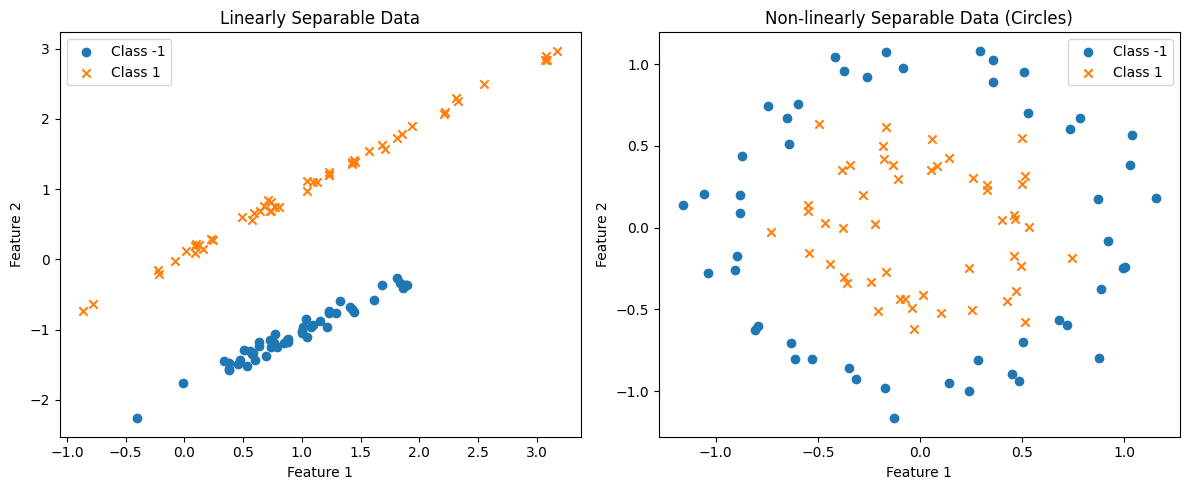

In [6]:
# Visualize the datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot linear data
axes[0].scatter(X_linear[y_linear == -1, 0], X_linear[y_linear == -1, 1], marker='o', label='Class -1')
axes[0].scatter(X_linear[y_linear == 1, 0], X_linear[y_linear == 1, 1], marker='x', label='Class 1')
axes[0].set_title('Linearly Separable Data')
axes[0].legend()
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Plot non-linear data
axes[1].scatter(X_nonlinear[y_nonlinear == -1, 0], X_nonlinear[y_nonlinear == -1, 1], marker='o', label='Class -1')
axes[1].scatter(X_nonlinear[y_nonlinear == 1, 0], X_nonlinear[y_nonlinear == 1, 1], marker='x', label='Class 1')
axes[1].set_title('Non-linearly Separable Data (Circles)')
axes[1].legend()
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [7]:
# Train and visualize Linear SVM from scratch
linear_svm = LinearSVM(learning_rate=0.01, lambda_param=0.01, n_iterations=1000)
linear_svm.fit(X_linear, y_linear)

In [8]:
# Plot decision boundary
def plot_decision_boundary(model, X, y, ax=None, title="Decision Boundary"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Set min and max values with some margin
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Create a meshgrid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Get the decision function values
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            x_test = np.array([xx[i, j], yy[i, j]])
            if hasattr(model, 'decision_function'):
                if isinstance(model, (LinearSVM, KernelSVM)):
                    # Our custom models
                    Z[i, j] = model.decision_function(x_test.reshape(1, -1))
                else:
                    # scikit-learn models
                    Z[i, j] = model.decision_function(x_test.reshape(1, -1))[0]
            else:
                # If no decision_function, use predict
                Z[i, j] = model.predict(x_test.reshape(1, -1))[0]

    # Plot the contour
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    ax.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['-'])

    # Plot the data points
    ax.scatter(X[y == -1, 0], X[y == -1, 1], marker='o', label='Class -1')
    ax.scatter(X[y == 1, 0], X[y == 1, 1], marker='x', label='Class 1')

    # Try to plot support vectors if available
    try:
        if hasattr(model, 'get_support_vectors'):
            sv_X, sv_y, _ = model.get_support_vectors(X, y)
            ax.scatter(sv_X[:, 0], sv_X[:, 1], s=100, facecolors='none', edgecolors='k', label='Support Vectors')
        elif hasattr(model, 'support_vectors_'):
            ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k', label='Support Vectors')
    except:
        pass

    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()

    return ax

<ipython-input-8-0c4d16ad04d0>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = model.decision_function(x_test.reshape(1, -1))


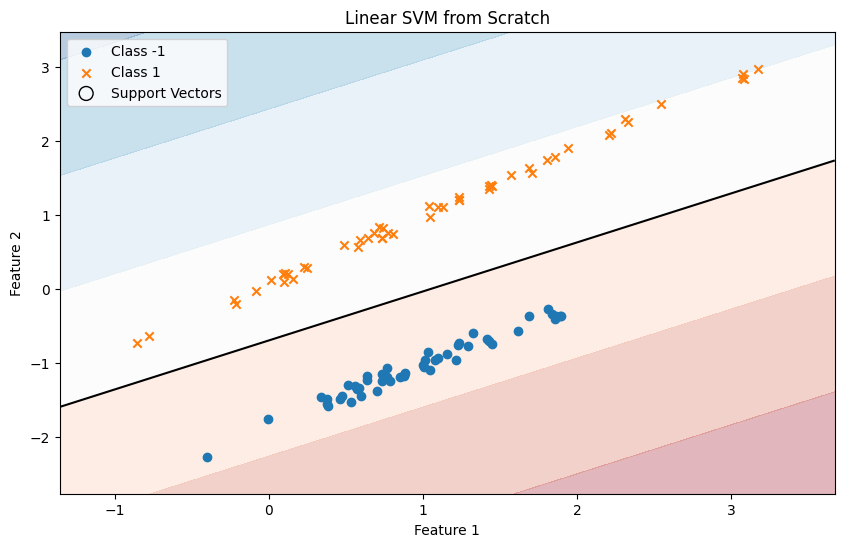

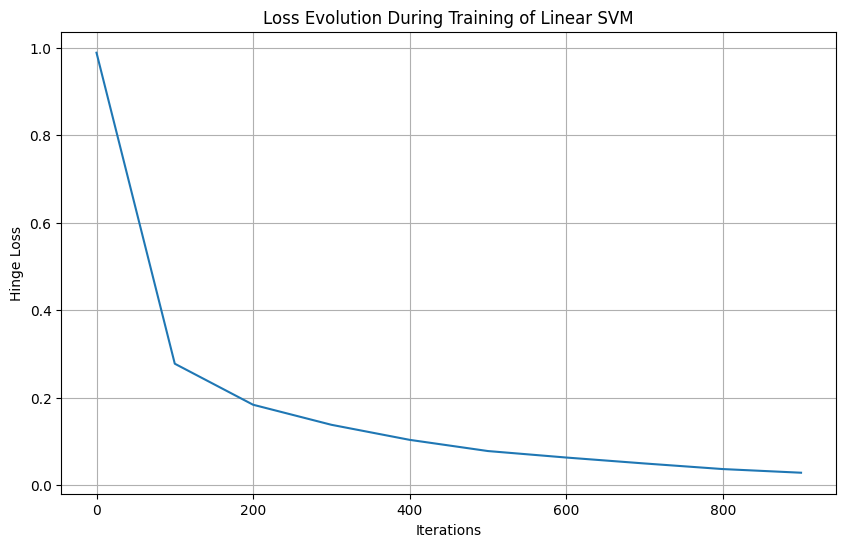

In [9]:
# Plot our linear SVM implementation
fig, ax = plt.subplots(figsize=(10, 6))
plot_decision_boundary(linear_svm, X_linear, y_linear, ax=ax, title="Linear SVM from Scratch")
plt.show()

# Plot the loss evolution during training
plt.figure(figsize=(10, 6))
plt.plot(range(0, linear_svm.n_iterations, 100), linear_svm.losses)
plt.title('Loss Evolution During Training of Linear SVM')
plt.xlabel('Iterations')
plt.ylabel('Hinge Loss')
plt.grid(True)
plt.show()

In [10]:
# Train and visualize Kernel SVM from scratch
kernel_svm = KernelSVM(C=1.0, kernel='rbf', gamma=1.0)
kernel_svm.fit(X_nonlinear, y_nonlinear)

<ipython-input-8-0c4d16ad04d0>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = model.decision_function(x_test.reshape(1, -1))


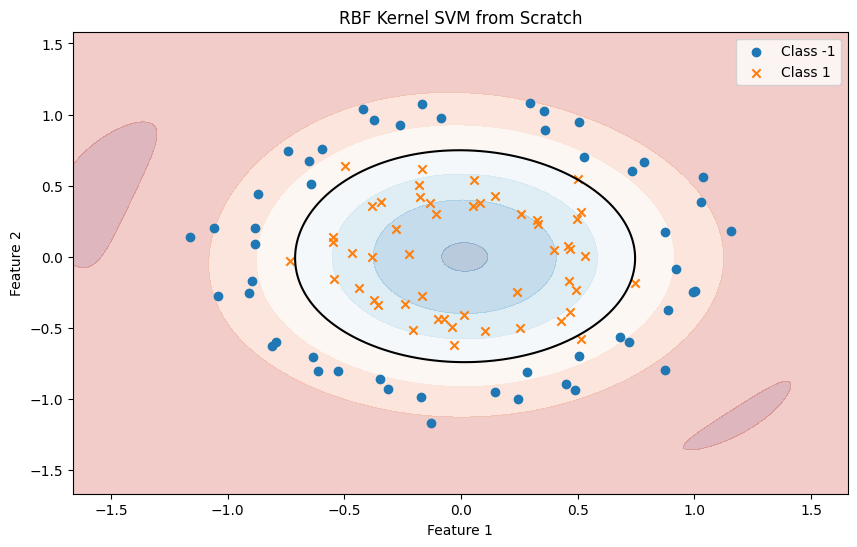

In [11]:
# Plot the kernel SVM decision boundary
fig, ax = plt.subplots(figsize=(10, 6))
plot_decision_boundary(kernel_svm, X_nonlinear, y_nonlinear, ax=ax, title="RBF Kernel SVM from Scratch")
plt.show()

# 2. Implementation using scikit-learn

In [12]:
# Train scikit-learn Linear SVM
sklearn_linear_svm = LinearSVC(dual=False, C=1.0, max_iter=2000)
sklearn_linear_svm.fit(X_linear, y_linear)

LinearSVC(dual=False, max_iter=2000)

In [13]:
# Also train SVC with linear kernel to get support vectors
sklearn_linear_svc = SVC(kernel='linear', C=1.0)
sklearn_linear_svc.fit(X_linear, y_linear)

SVC(kernel='linear')

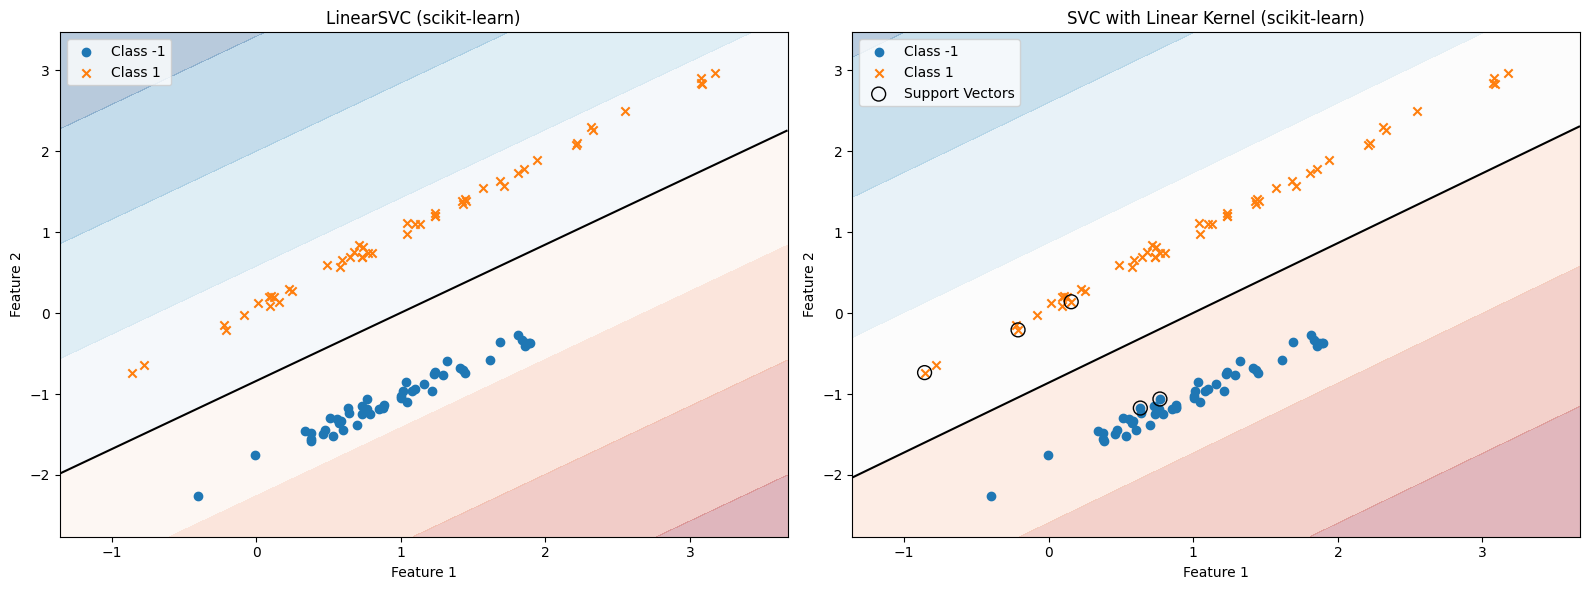

In [14]:
# Plot decision boundary
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot LinearSVC
plot_decision_boundary(sklearn_linear_svm, X_linear, y_linear, ax=axes[0], title="LinearSVC (scikit-learn)")

# Plot SVC with linear kernel
plot_decision_boundary(sklearn_linear_svc, X_linear, y_linear, ax=axes[1], title="SVC with Linear Kernel (scikit-learn)")

plt.tight_layout()
plt.show()

## 2.2 Kernel SVM with scikit-learn

In [16]:
# Train scikit-learn Kernel SVMs
sklearn_rbf_svm = SVC(kernel='rbf', C=1.0, gamma=1.0)
sklearn_rbf_svm.fit(X_nonlinear, y_nonlinear)

SVC(gamma=1.0)

In [17]:
sklearn_poly_svm = SVC(kernel='poly', C=1.0, degree=3, gamma='scale')
sklearn_poly_svm.fit(X_nonlinear, y_nonlinear)

SVC(kernel='poly')

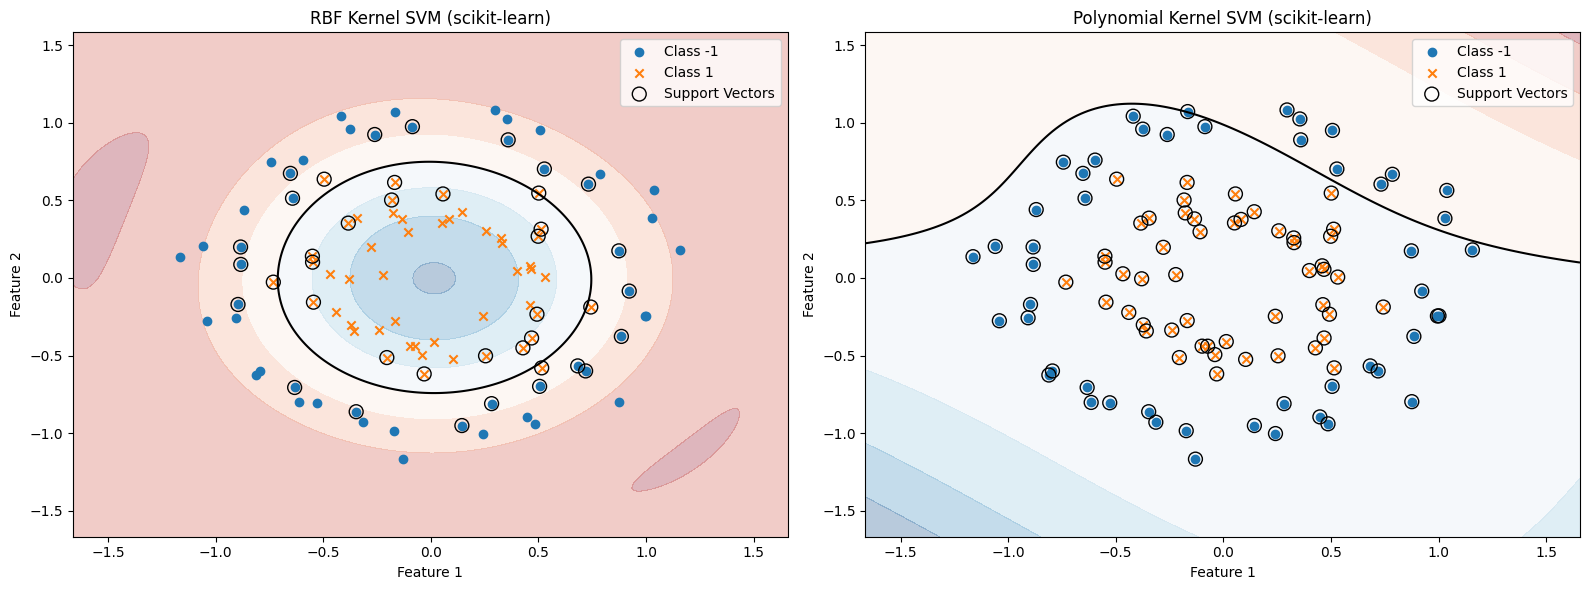

In [18]:
# Plot decision boundaries
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot RBF kernel SVM
plot_decision_boundary(sklearn_rbf_svm, X_nonlinear, y_nonlinear, ax=axes[0], title="RBF Kernel SVM (scikit-learn)")

# Plot Polynomial kernel SVM
plot_decision_boundary(sklearn_poly_svm, X_nonlinear, y_nonlinear, ax=axes[1], title="Polynomial Kernel SVM (scikit-learn)")

plt.tight_layout()
plt.show()

# 3. Visualizations

## 3.1 Decision Boundaries

In [19]:
# Create a more complex non-linearly separable dataset
X_complex, y_complex = make_blobs(n_samples=100, centers=4, n_features=2, random_state=42)
y_complex = np.where(y_complex % 2 == 0, -1, 1)  # Convert to binary classification

In [20]:
# Scale data for better visualization
scaler = StandardScaler()
X_complex_scaled = scaler.fit_transform(X_complex)

In [21]:
# Train different kernel SVMs
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1.0, 10.0]

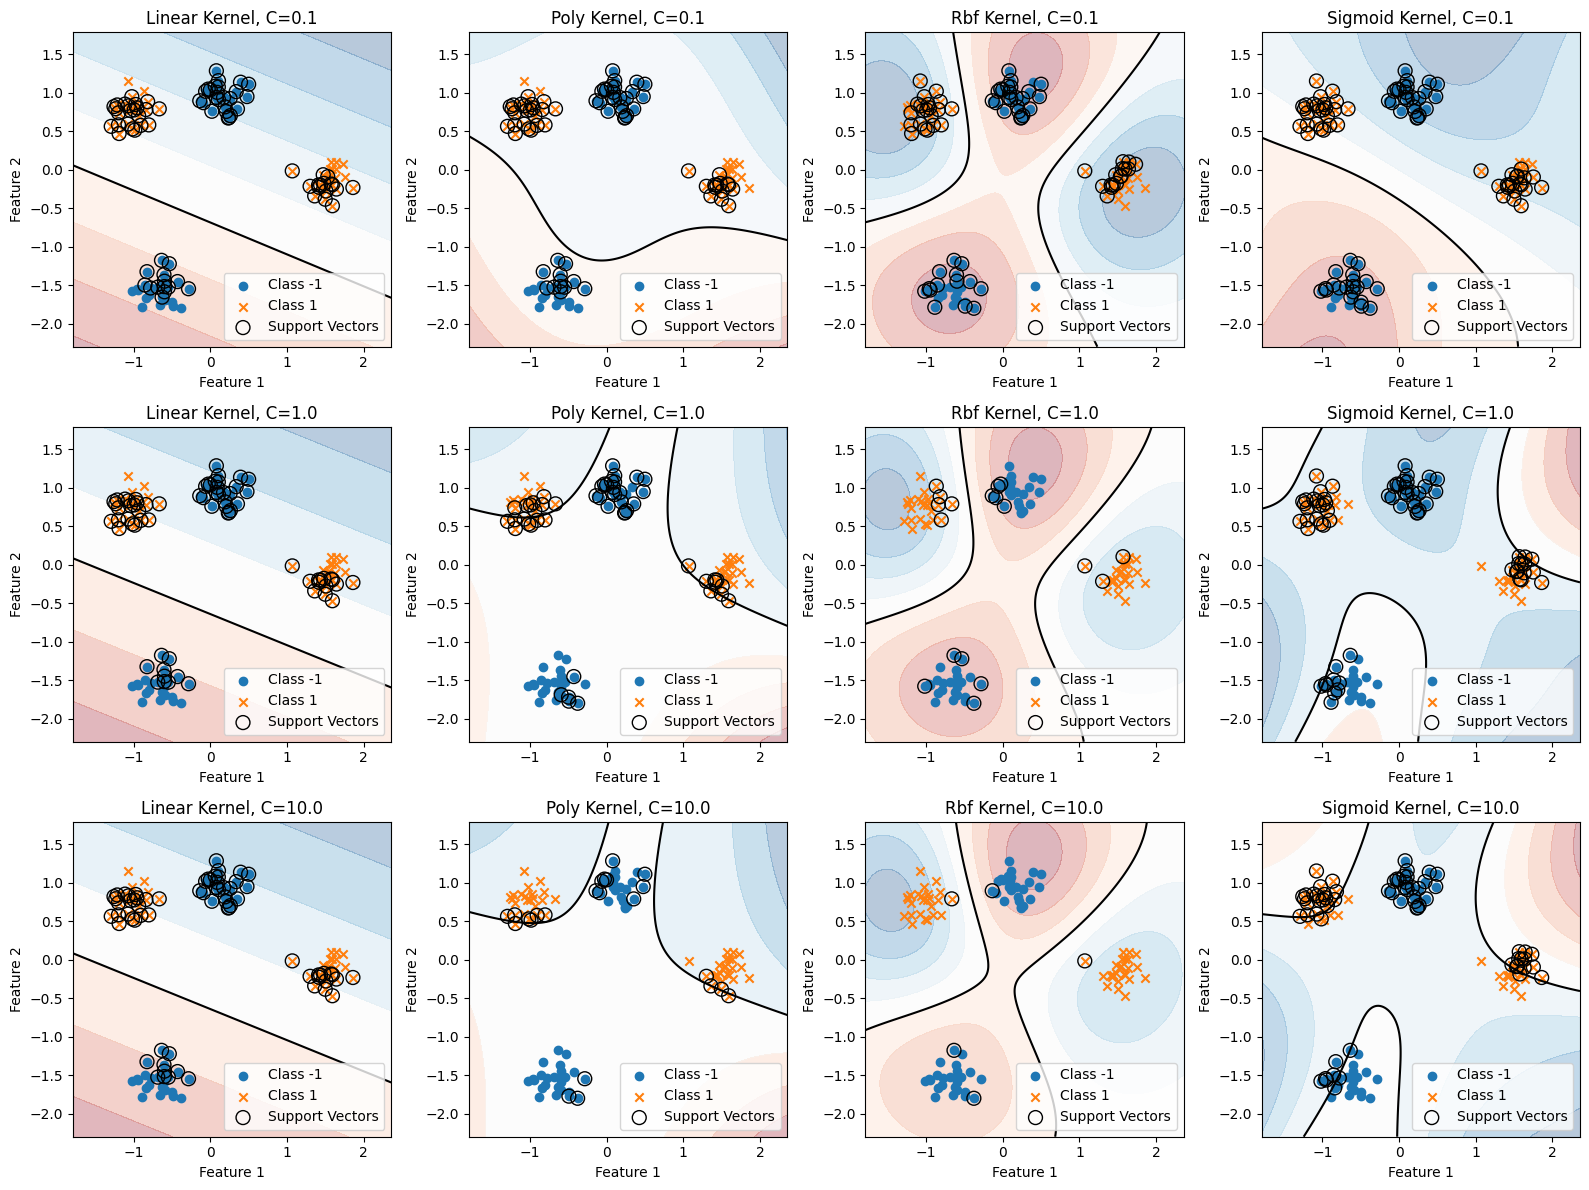

In [22]:
# Create a grid of plots
fig, axes = plt.subplots(len(C_values), len(kernels), figsize=(16, 12))

for i, C in enumerate(C_values):
    for j, kernel in enumerate(kernels):
        # Train SVM with current parameters
        svm = SVC(kernel=kernel, C=C, gamma='scale')
        svm.fit(X_complex_scaled, y_complex)

        # Plot decision boundary
        plot_decision_boundary(svm, X_complex_scaled, y_complex, ax=axes[i, j],
                               title=f"{kernel.capitalize()} Kernel, C={C}")

plt.tight_layout()
plt.show()

## 3.2 Support Vectors

In [23]:
# Create a function to visualize support vectors with margins
def plot_svm_with_margins(svm, X, y, ax=None, title="SVM with Margins"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Set min and max values with some margin
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Create a meshgrid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Use scikit-learn's DecisionBoundaryDisplay
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

    # Plot the decision boundary and margins
    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'], linewidths=[1, 2, 1])

    # Plot the data points
    ax.scatter(X[y == -1, 0], X[y == -1, 1], marker='o', label='Class -1')
    ax.scatter(X[y == 1, 0], X[y == 1, 1], marker='x', label='Class 1')

    # Highlight support vectors
    ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=100,
               facecolors='none', edgecolors='k', linewidths=2, label='Support Vectors')

    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()

    return ax

In [25]:
# Train linear SVM for better margin visualization
X_margin, y_margin = make_classification(n_samples=100, n_features=2, n_redundant=0,
                                         n_informative=2, random_state=1, n_clusters_per_class=1)
y_margin = np.where(y_margin == 0, -1, 1)  # Convert labels to -1 and 1

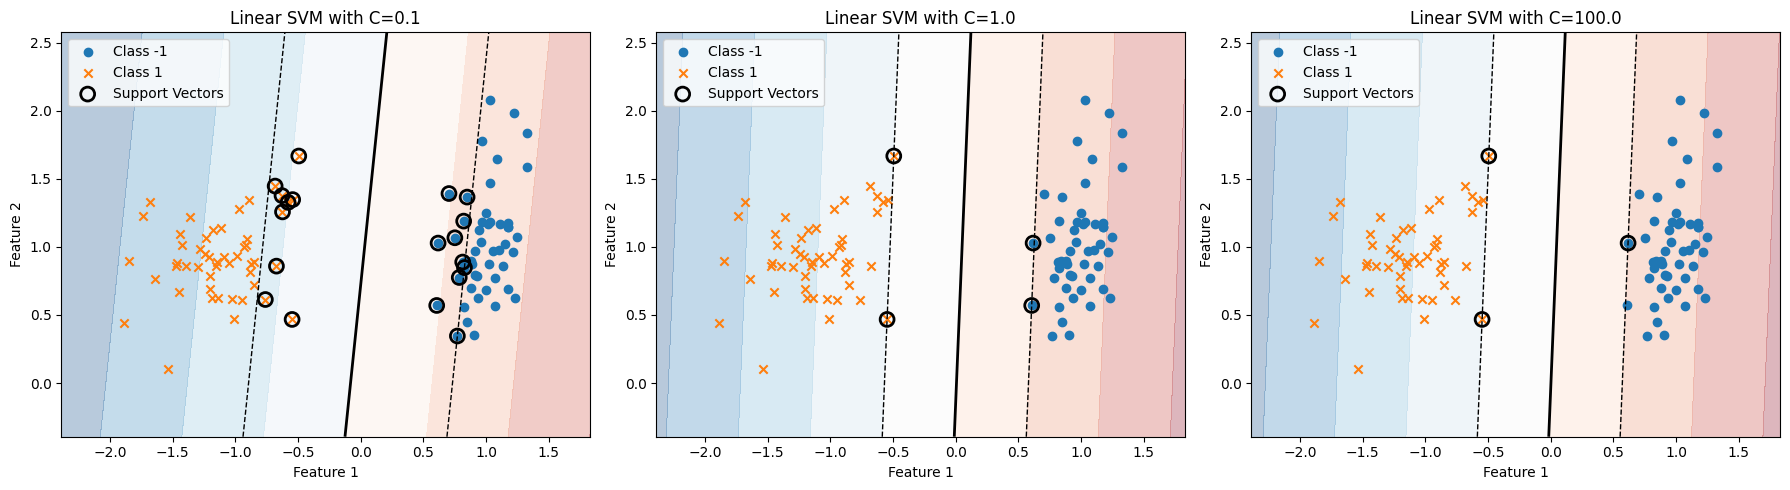

In [26]:
# Create SVMs with different C values to show margin effect
C_values = [0.1, 1.0, 100.0]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, C in enumerate(C_values):
    svm = SVC(kernel='linear', C=C)
    svm.fit(X_margin, y_margin)
    plot_svm_with_margins(svm, X_margin, y_margin, ax=axes[i],
                          title=f"Linear SVM with C={C}")

plt.tight_layout()
plt.show()

## 3.3 Margin Visualization

In [27]:
def plot_svm_interactive(C=1.0, kernel='linear', gamma=1.0, degree=3):
    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create SVM model
    svm = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree)

    # Use X_complex_scaled dataset
    svm.fit(X_complex_scaled, y_complex)

    # Plot decision boundary
    plot_svm_with_margins(svm, X_complex_scaled, y_complex, ax=ax,
                         title=f"SVM with {kernel} kernel, C={C}, gamma={gamma}, degree={degree}")

    plt.tight_layout()
    plt.show()

    # Print support vector information
    print(f"Number of support vectors: {svm.n_support_}")
    print(f"Percentage of training data used as support vectors: {sum(svm.n_support_) / len(X_complex_scaled):.2%}")


In [28]:
# Create interactive widget
C_slider = widgets.FloatLogSlider(value=1.0, base=10, min=-1, max=2, step=0.1, description='C:')
kernel_dropdown = widgets.Dropdown(options=['linear', 'poly', 'rbf', 'sigmoid'], value='rbf', description='Kernel:')
gamma_slider = widgets.FloatLogSlider(value=1.0, base=10, min=-2, max=2, step=0.1, description='Gamma:')
degree_slider = widgets.IntSlider(value=3, min=1, max=10, step=1, description='Degree:')

In [29]:
# Display the interactive widget
interact(plot_svm_interactive, C=C_slider, kernel=kernel_dropdown, gamma=gamma_slider, degree=degree_slider)

interactive(children=(FloatLogSlider(value=1.0, description='C:', max=2.0, min=-1.0), Dropdown(description='Ke…

<function __main__.plot_svm_interactive(C=1.0, kernel='linear', gamma=1.0, degree=3)>

## 3.4 Feature Importance

In [30]:
# Load a real dataset for feature importance demonstration
breast_cancer = load_breast_cancer()
X_cancer = breast_cancer.data
y_cancer = breast_cancer.target
feature_names = breast_cancer.feature_names

In [31]:
# Scale the data
X_cancer_scaled = StandardScaler().fit_transform(X_cancer)

In [32]:
# Train a linear SVM
linear_svm_cancer = LinearSVC(C=1.0, max_iter=10000)
linear_svm_cancer.fit(X_cancer_scaled, y_cancer)

LinearSVC(max_iter=10000)

In [33]:
# Get feature importance
feature_importance = np.abs(linear_svm_cancer.coef_[0])
sorted_idx = np.argsort(feature_importance)

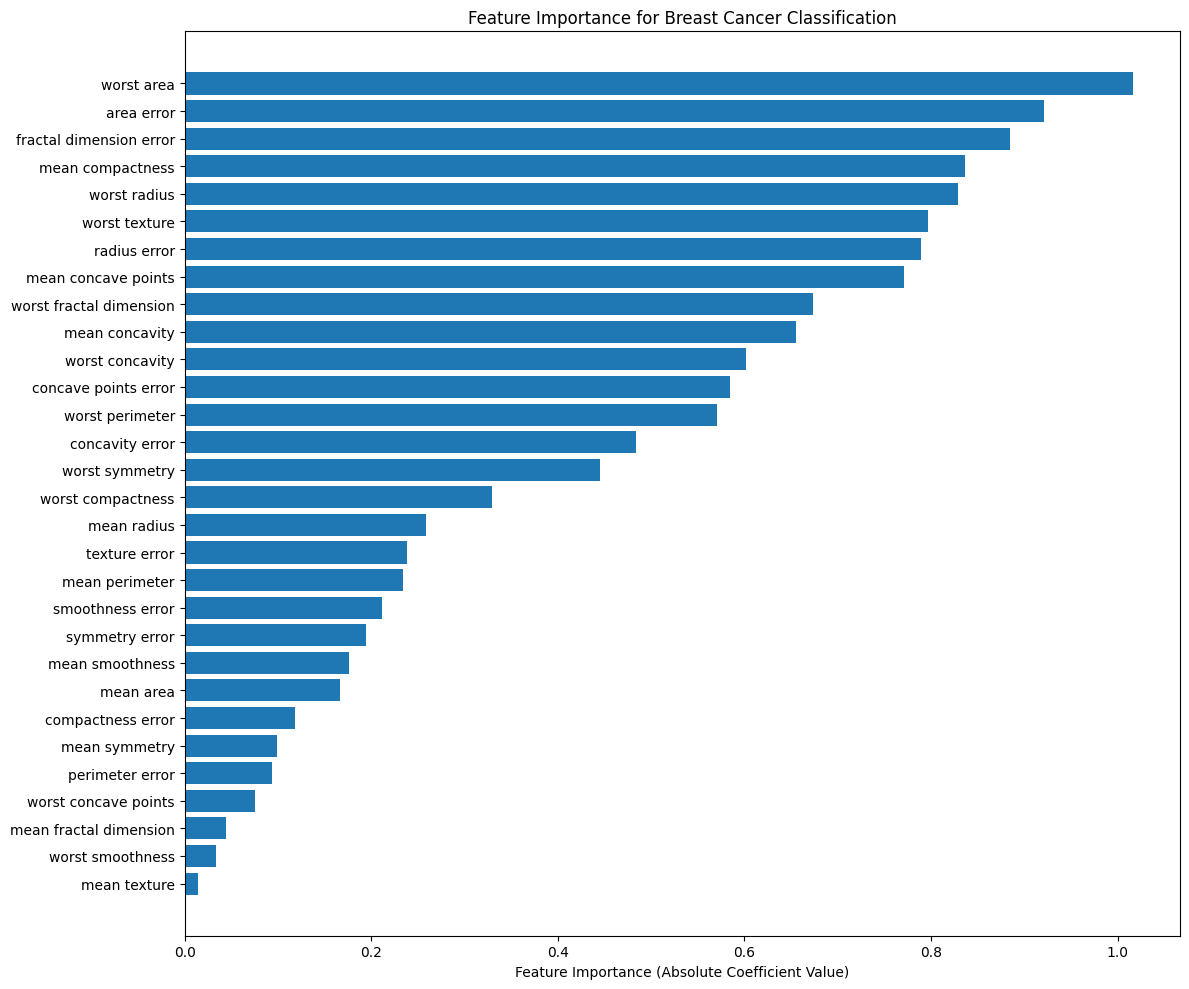

In [34]:
# Plot feature importance
plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance (Absolute Coefficient Value)')
plt.title('Feature Importance for Breast Cancer Classification')
plt.tight_layout()
plt.show()

# 4. Model Evaluation and Interpretation

## 4.1 Performance Metrics

In [35]:
# Split breast cancer dataset
X_train, X_test, y_train, y_test = train_test_split(X_cancer_scaled, y_cancer, test_size=0.3, random_state=42)

In [37]:
# Train SVM models with different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_models = {}
results = {}

for kernel in kernels:
    # Train model
    svm_models[kernel] = SVC(kernel=kernel, C=1.0, probability=True)
    svm_models[kernel].fit(X_train, y_train)

    # Predict on test set
    y_pred = svm_models[kernel].predict(X_test)

    # Calculate metrics
    results[kernel] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

    print(f"Results for SVM with {kernel} kernel:")
    print(f"Accuracy: {results[kernel]['accuracy']:.4f}")
    print("Classification Report:")
    print(results[kernel]['classification_report'])
    print("-" * 50)

Results for SVM with linear kernel:
Accuracy: 0.9766
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171

--------------------------------------------------
Results for SVM with poly kernel:
Accuracy: 0.8947
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83        63
           1       0.86      1.00      0.92       108

    accuracy                           0.89       171
   macro avg       0.93      0.86      0.88       171
weighted avg       0.91      0.89      0.89       171

--------------------------------------------------
Results for SVM with rbf kernel:
Accuracy: 0.9708
Classification Report:
              precisi

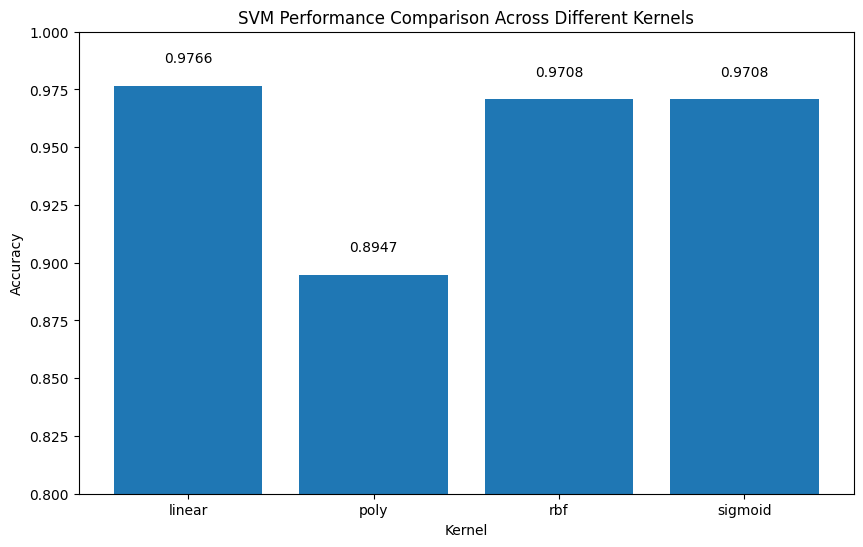

In [38]:
# Create a bar chart comparing accuracies
plt.figure(figsize=(10, 6))
accuracies = [results[kernel]['accuracy'] for kernel in kernels]
plt.bar(kernels, accuracies)
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.title('SVM Performance Comparison Across Different Kernels')
plt.ylim(0.8, 1.0)  # Adjust y-axis for better visualization
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()

## 4.2 ROC and Precision-Recall Curves

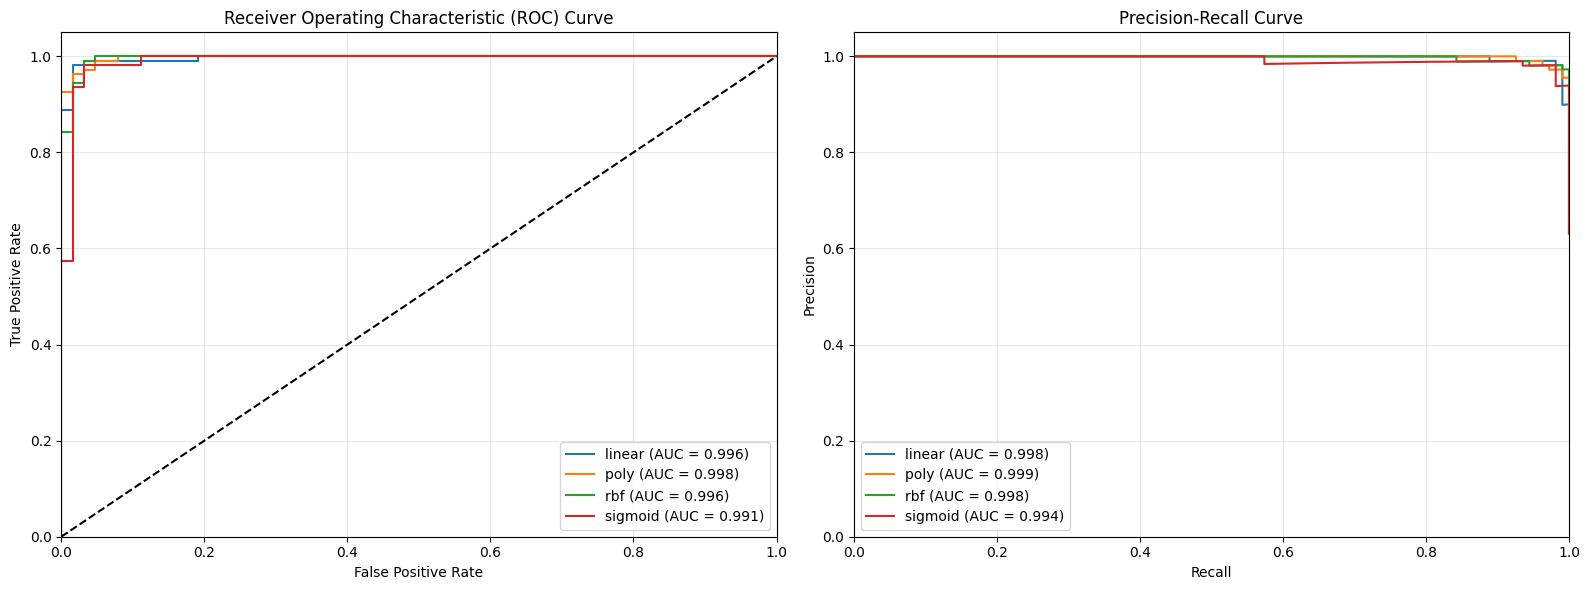

In [39]:
# Plot ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for kernel in kernels:
    svm = svm_models[kernel]

    # ROC curve
    y_score = svm.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    axes[0].plot(fpr, tpr, label=f'{kernel} (AUC = {roc_auc:.3f})')

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    pr_auc = auc(recall, precision)

    axes[1].plot(recall, precision, label=f'{kernel} (AUC = {pr_auc:.3f})')

# ROC curve formatting
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall curve formatting
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.3 Cross-validation

In [40]:
# Perform cross-validation for different kernel types
cv_results = {}

for kernel in kernels:
    svm = SVC(kernel=kernel, C=1.0)
    scores = cross_val_score(svm, X_cancer_scaled, y_cancer, cv=5, scoring='accuracy')
    cv_results[kernel] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }

<ipython-input-41-90e3b9eb9f27>:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=kernels, patch_artist=True)


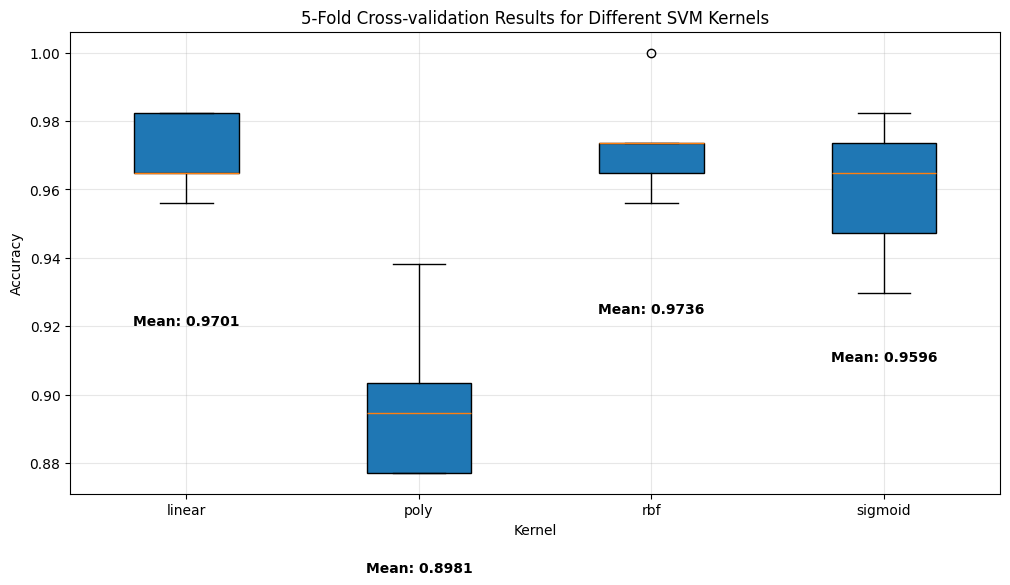

In [41]:
# Plot cross-validation results
plt.figure(figsize=(12, 6))

# Create box plots
data = [cv_results[kernel]['scores'] for kernel in kernels]
plt.boxplot(data, labels=kernels, patch_artist=True)

# Add mean accuracy values
for i, kernel in enumerate(kernels):
    plt.text(i+1, cv_results[kernel]['mean'] - 0.05,
             f"Mean: {cv_results[kernel]['mean']:.4f}",
             ha='center', fontweight='bold')

plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-validation Results for Different SVM Kernels')
plt.grid(True, alpha=0.3)
plt.show()

# 5. Hyperparameter Tuning

In [42]:
# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf']
}

# Create SVM model
svm = SVC(probability=True)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_cancer_scaled, y_cancer)

GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [43]:
# Display best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.9789


In [47]:
# Get detailed results
results_df = pd.DataFrame(grid_search.cv_results_)

In [50]:
# Extract most important parameters for visualization
pivot_table = pd.DataFrame()
rows_list = []  # Store rows in a list to concat later

for kernel in ['linear', 'poly', 'rbf']:
    kernel_results = results_df[results_df['param_kernel'] == kernel]
    for C in [0.1, 1, 10, 100]:
        C_results = kernel_results[kernel_results['param_C'] == C]
        if kernel == 'linear':
            # Linear kernel doesn't use gamma
            try:
                row = C_results.iloc[0]
                rows_list.append({
                    'kernel': kernel,
                    'C': C,
                    'gamma': 'N/A',
                    'mean_test_score': row['mean_test_score']
                })
            except IndexError:
                continue
        else:
            for gamma in [0.01, 0.1, 1, 'scale', 'auto']:
                try:
                    gamma_results = C_results[C_results['param_gamma'] == gamma]
                    row = gamma_results.iloc[0]
                    rows_list.append({
                        'kernel': kernel,
                        'C': C,
                        'gamma': gamma,
                        'mean_test_score': row['mean_test_score']
                    })
                except IndexError:
                    continue

# Combine all rows into the pivot table
pivot_table = pd.concat([pivot_table, pd.DataFrame(rows_list)], ignore_index=True)

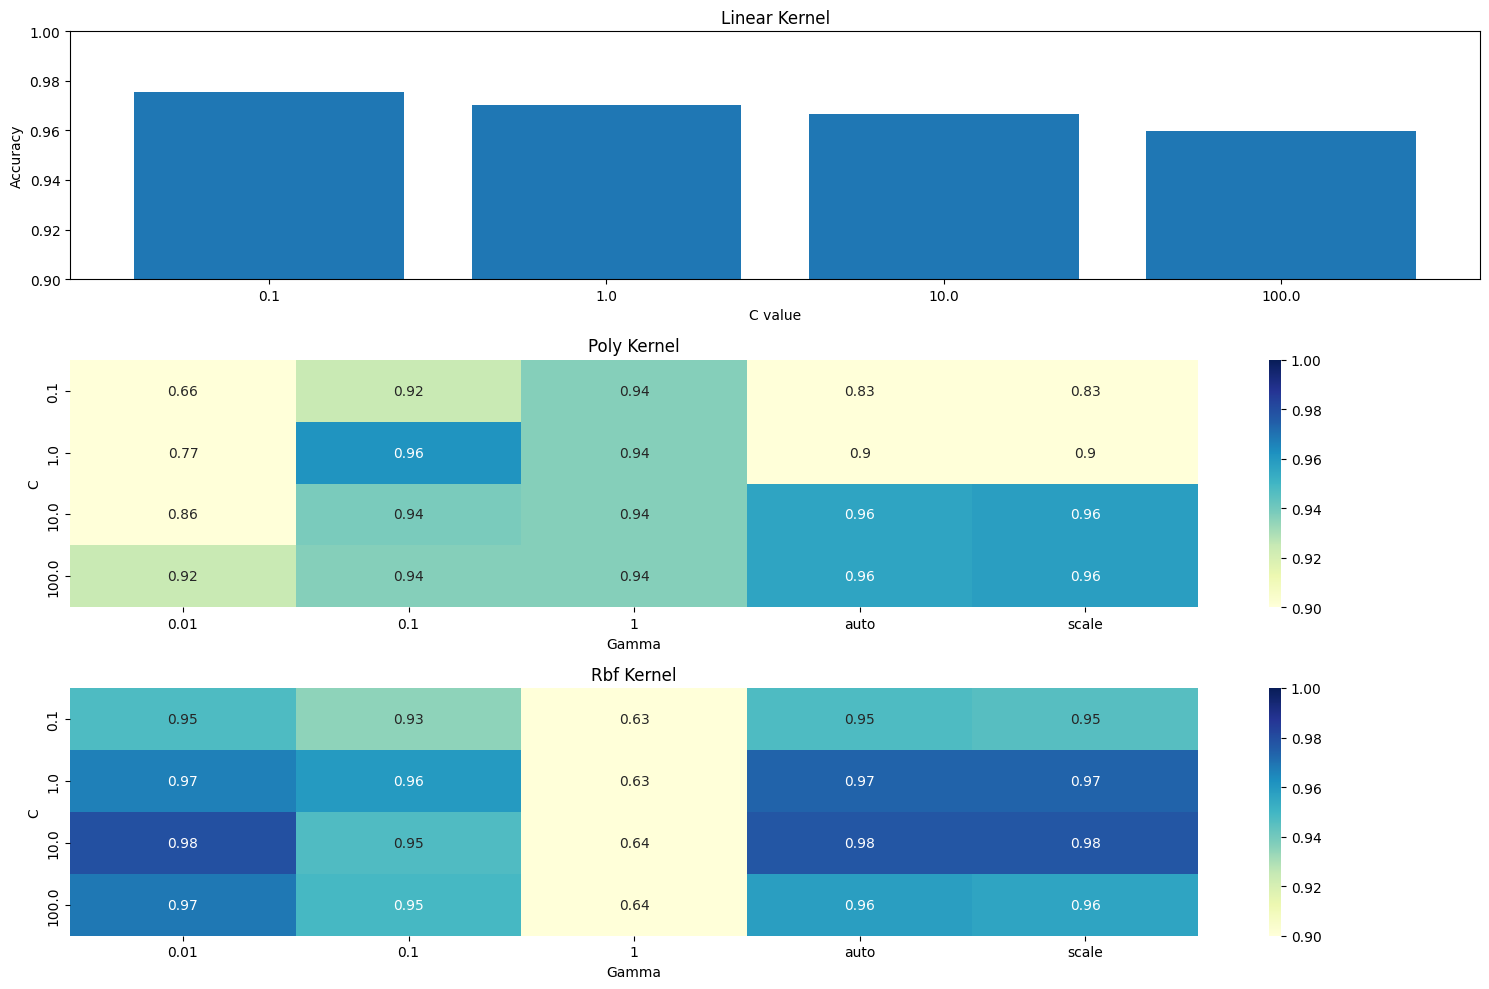

In [51]:
# Plot grid search results
plt.figure(figsize=(15, 10))

# Group by kernel for plotting
for i, kernel in enumerate(['linear', 'poly', 'rbf']):
    kernel_data = pivot_table[pivot_table['kernel'] == kernel]

    if kernel == 'linear':
        # Linear kernel doesn't use gamma, just plot against C
        C_values = kernel_data['C'].astype(str).values
        scores = kernel_data['mean_test_score'].values

        plt.subplot(3, 1, i+1)
        plt.bar(C_values, scores)
        plt.title(f'{kernel.capitalize()} Kernel')
        plt.xlabel('C value')
        plt.ylabel('Accuracy')
        plt.ylim(0.90, 1.0)
    else:
        # For other kernels, create heatmap with C and gamma
        # Handle potential empty dataframes
        if not kernel_data.empty:
            try:
                pivot = kernel_data.pivot_table(
                    values='mean_test_score',
                    index='C',
                    columns='gamma'
                )

                plt.subplot(3, 1, i+1)
                sns.heatmap(pivot, annot=True, cmap='YlGnBu', vmin=0.9, vmax=1.0)
                plt.title(f'{kernel.capitalize()} Kernel')
                plt.xlabel('Gamma')
                plt.ylabel('C')
            except ValueError as e:
                plt.subplot(3, 1, i+1)
                plt.text(0.5, 0.5, f"Error creating heatmap: {str(e)}",
                         ha='center', va='center', transform=plt.gca().transAxes)
                plt.title(f'{kernel.capitalize()} Kernel - Error')
        else:
            plt.subplot(3, 1, i+1)
            plt.text(0.5, 0.5, "No data available for this kernel",
                     ha='center', va='center', transform=plt.gca().transAxes)
            plt.title(f'{kernel.capitalize()} Kernel - No Data')

plt.tight_layout()
plt.show()

In [52]:
# Get best model from grid search
best_svm = grid_search.best_estimator_

# Evaluate best model on test set
X_train, X_test, y_train, y_test = train_test_split(X_cancer_scaled, y_cancer, test_size=0.3, random_state=42)
y_pred = best_svm.predict(X_test)

print(f"Best model test accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Best model test accuracy: 0.9883
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.98      1.00      0.99       108

    accuracy                           0.99       171
   macro avg       0.99      0.98      0.99       171
weighted avg       0.99      0.99      0.99       171



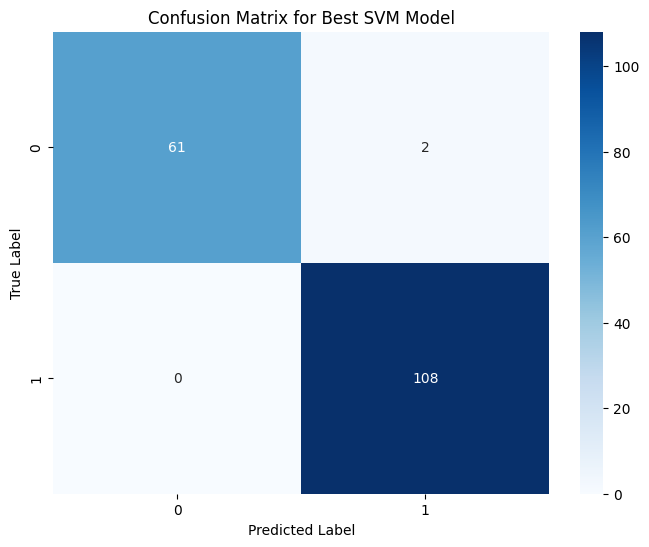

In [53]:
# Confusion matrix for best model
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()